# Process preedited 4T1 in vitro zombie MERFISH data

**Author:** William Colgan <br>
**Date:** July 10 2024 <br>
**Enviromnent:** py10-env <br>

## Purpose

This notebook processes MERFISH data from a lineage tracing experiment. It calls clones based on shared target sites and identifies doublets. It also processes target site spots, filtering out dim spots, removing target sites with multiple integrations, and finally assigning a unique target site allele to each cell.

## Setup

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import treedata as td
import ast
import geopandas as gpd
import numpy as np
from sklearn.decomposition import NMF
from pathlib import Path
import sys
np.random.seed(42)

Configure paths

In [37]:
base_path = Path("/lab/solexa_weissman/PEtracing_shared/PETracer_Paper/")
data_path = base_path / "preedited" / "data"
results_path = base_path  / "preedited" / "results"  
reference_path = base_path / "reference"
sys.path.append(str(base_path))
plt.style.use(base_path / 'plot.mplstyle')

Load helper functions

In [38]:
from src.config import colors, sequential_cmap, site_names, discrete_cmap
from src.ts_utils import assign_clones
site_names = list(site_names.keys())

Configure plotting

In [39]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors[1:])

## Load data

Specify samples and names

In [40]:
samples = {"4T1_preedited":Path("/lab/weissman_imaging/wcolgan/MERFISH_Data/20240508-4T1fullyEdited_zombie_IntBCv2new_editv3")}

Cells

In [41]:
cells = []
for sample, path in samples.items():
    sample_cells = gpd.read_file(path / "cells.json")
    sample_cells.crs = None
    sample_cells["sample"] = sample
    sample_cells["cellBC"] = (sample + "-" + sample_cells["cell"].astype(str))
    cells.append(sample_cells.drop(columns=["cell"]))
cells = gpd.GeoDataFrame(pd.concat(cells, ignore_index=True))
cells.index = cells.cellBC.values
adata = ad.AnnData(obs=cells)
adata.obs["type"] = "normal"

Target site

In [42]:
alleles = []
for sample, path in samples.items():
    sample_alleles =  pd.read_csv(f"{path}/decoded_spots.csv",keep_default_na=False,index_col=0)
    sample_alleles["intensity"] = sample_alleles["intensity"].apply(ast.literal_eval)
    sample_alleles["sample"] = sample
    sample_alleles["cellBC"] = (sample + "-" + sample_cells["cell"].astype(str))
    alleles.append(sample_alleles)
alleles = pd.concat(alleles)
alleles = alleles[alleles["cellBC"].isin(cells.cellBC)]

## Imaging statistics

Cells per sample

<Axes: xlabel='sample', ylabel='count'>

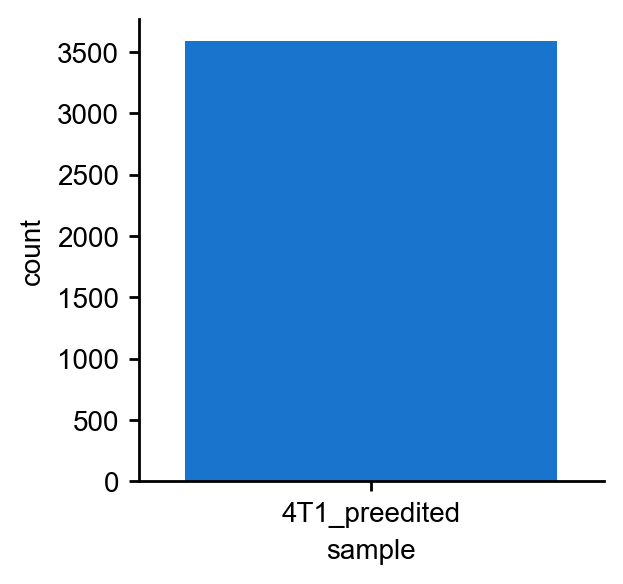

In [43]:
sns.countplot(data = adata.obs, x = "sample",hue = "sample",legend=False,saturation = 1)

intBC intensity vs distance

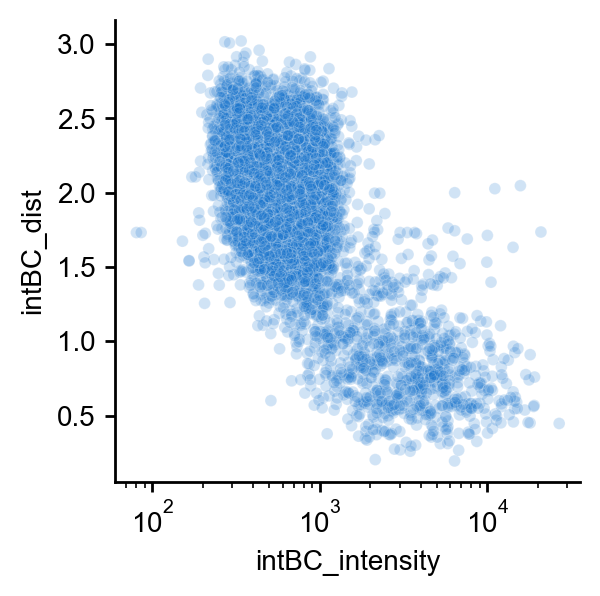

In [44]:
sns.scatterplot(data =alleles.sample(10000), x = "intBC_intensity", y = "intBC_dist",
                hue = "sample",legend=False,alpha = 0.2,size = .1)
plt.xscale("log")

## Filter target site spots

In [45]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = alleles.query("cellBC.isin(@normal_cells)").copy()

Set distance and intensity cutoffs

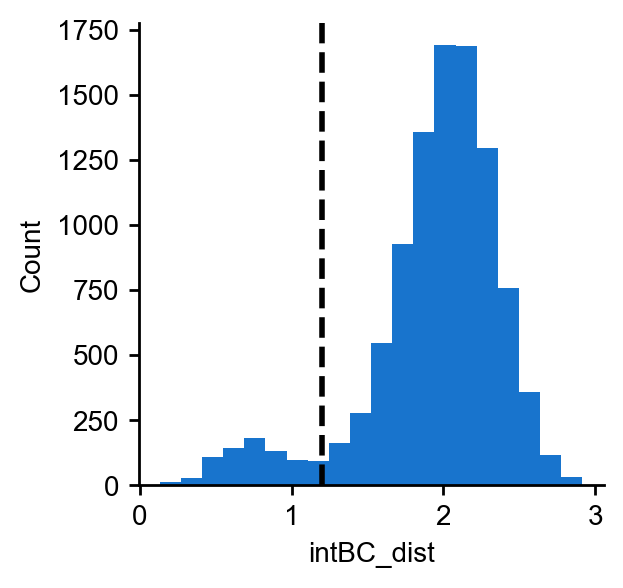

In [46]:
max_dist = 1.2
unique_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index()
sns.histplot(data = unique_alleles.sample(10000),x = "intBC_dist",hue = "sample",legend=False,multiple="stack",linewidth=0,bins = 20,alpha = 1) 
plt.axvline(max_dist, linestyle="--",color = "black")

Spots per cell per sample

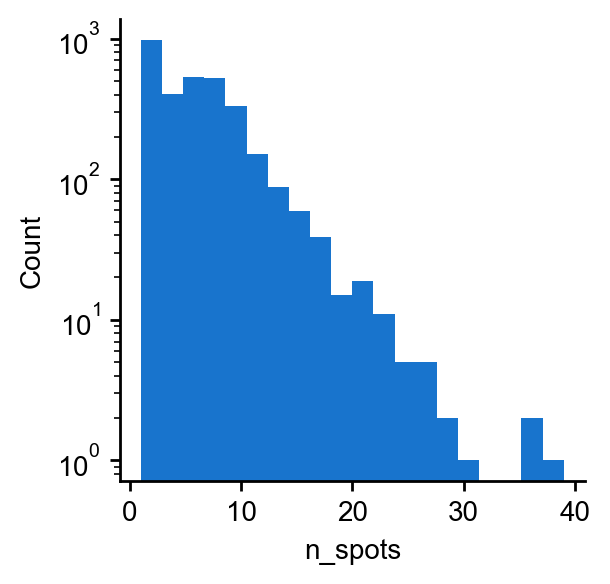

In [28]:
filtered_alleles = filtered_alleles.query("decoded").drop(columns = "decoded").copy()
sns.histplot(data = filtered_alleles.groupby(["sample","cellBC"]).size().reset_index(name = "n_spots"), 
            x = "n_spots",hue = "sample",legend=False,multiple="stack",linewidth=0,bins = 20,alpha = 1)
plt.yscale("log")

## Assign clones

Load clone whitelist

In [14]:
clone_whitelist = pd.read_csv(data_path / "preedited_clone_whitelist.csv",
                              keep_default_na=False,dtype={"clone":str})

Assign cells to clones using jaccard similarity

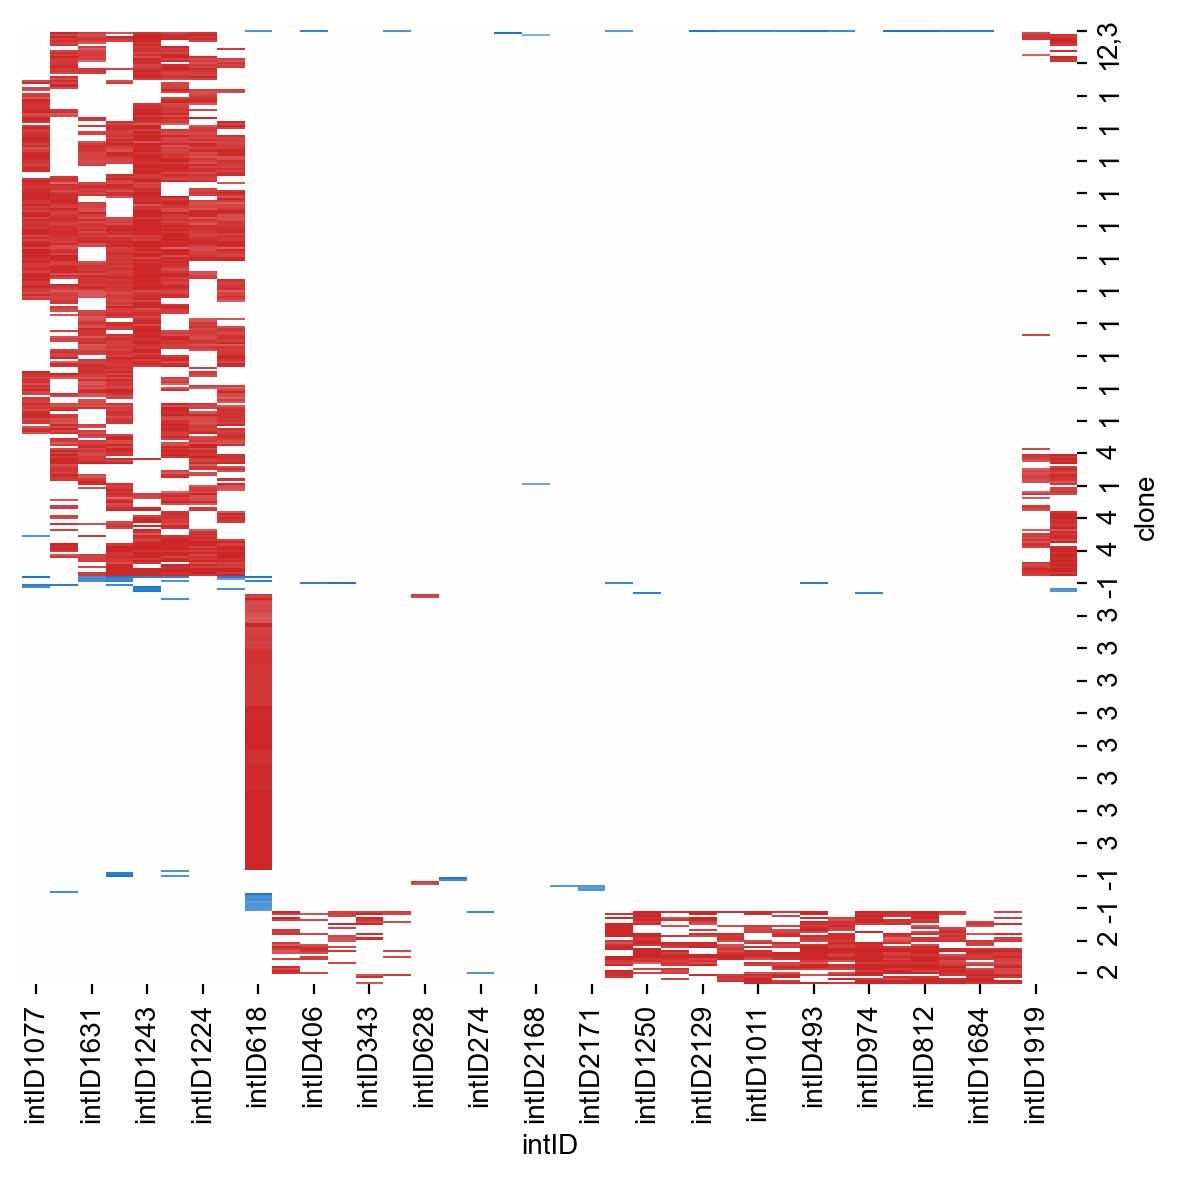

In [15]:
min_jaccard = .2
whitelist_alleles = []
cell_to_clone = []
for sample in alleles["sample"].unique():
    sample_alleles, sample_clones = assign_clones(filtered_alleles, clone_whitelist = clone_whitelist,top_n = 50,
                                doublets=True,plot = True,min_jaccard = min_jaccard)
    whitelist_alleles.append(sample_alleles)
    cell_to_clone.append(sample_clones.assign(sample = sample))
whitelist_alleles = pd.concat(whitelist_alleles)
cell_to_clone = pd.concat(cell_to_clone)

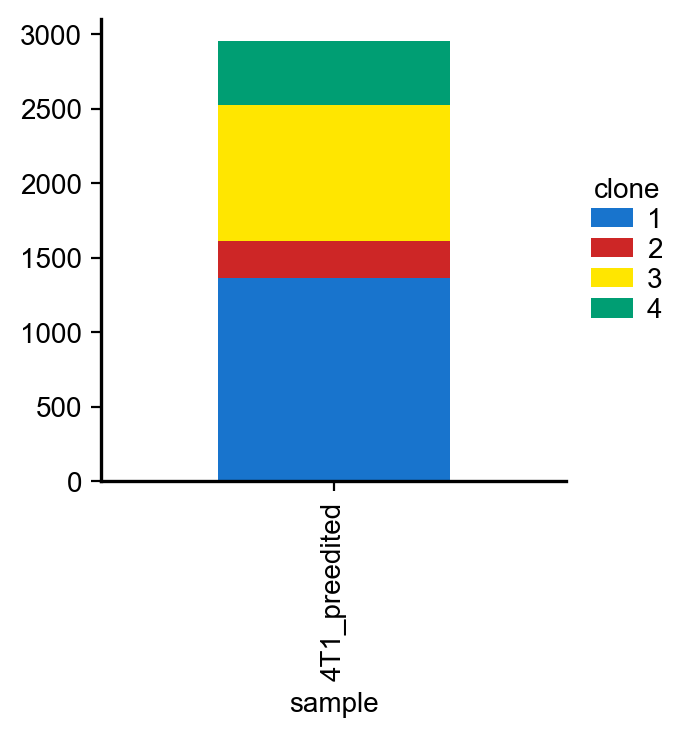

In [16]:
filtered_alleles = whitelist_alleles.copy()
cell_to_clone = cell_to_clone.query("whitelist").copy()
filtered_alleles["clone"] = filtered_alleles["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])
adata.obs["clone"] = adata.obs["cellBC"].map(cell_to_clone.set_index("cellBC")["clone"])
adata.obs.groupby(['sample', 'clone'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='clone', bbox_to_anchor=(1, 0.5))

Spatial organization of clones

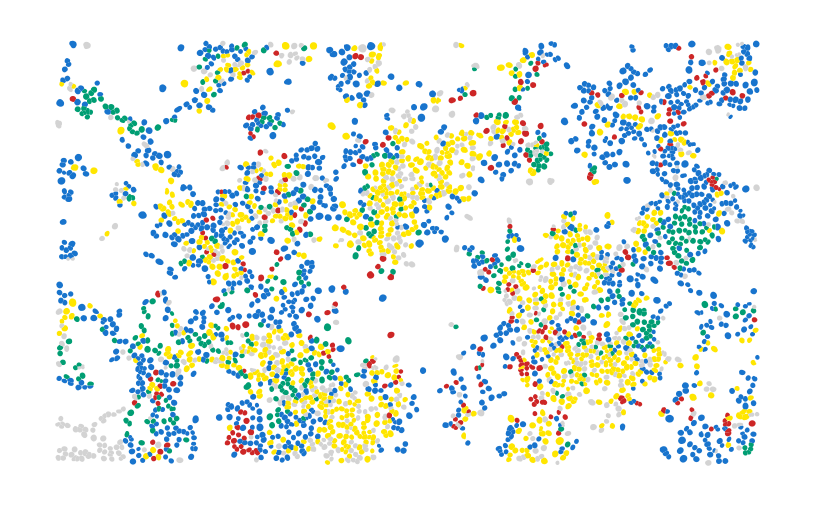

In [17]:
clones = list(adata.obs.clone.dropna().unique())
clone_colors = {sample:color for sample, color in zip(sorted(clones),colors[1:])}
fig, ax = plt.subplots(figsize = (5,5))
adata.obs.plot(color = adata.obs["clone"].map(clone_colors).fillna("lightgray"),legend = False,ax = ax)
ax.axis('off');

Mark doublets and unassigned cells

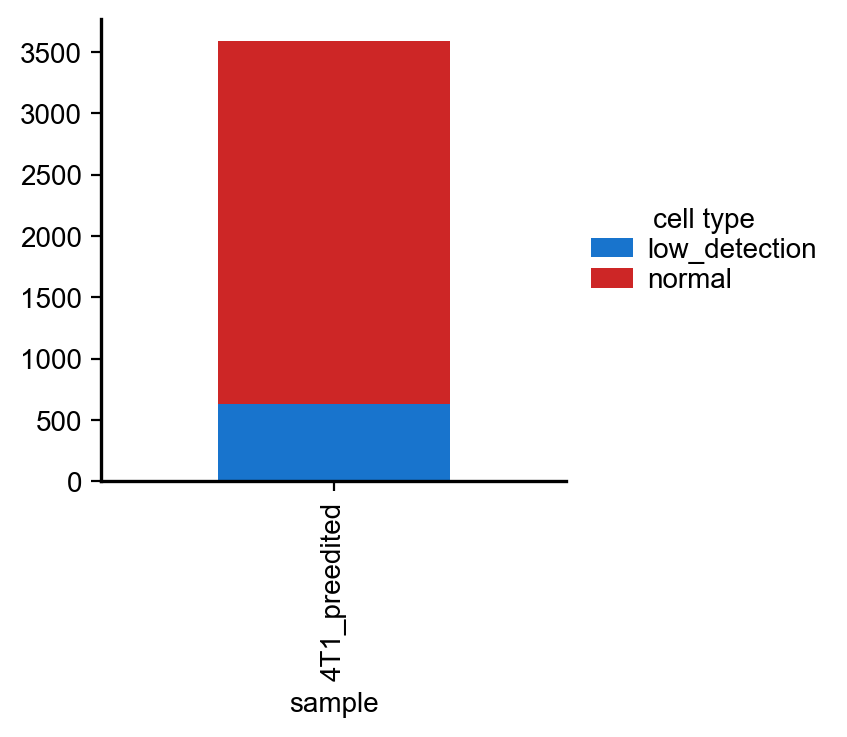

In [18]:
doublets = cell_to_clone.query("clone.str.contains(',')")["cellBC"]
adata.obs.loc[doublets, "type"] = "doublet"
adata.obs.loc[(adata.obs["type"] == "normal") & adata.obs.clone.isna(), "type"] = "low_detection"
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Decode alleles

Setup

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

Load data

In [20]:
rounds = pd.read_csv(data_path / "imaging_rounds.csv",keep_default_na=False)
rounds = rounds.query("type.isin(['common','integration','edit'])").reset_index(drop = True)
clone_whitelist = pd.read_csv(data_path / "preedited_clone_whitelist.csv",
                              keep_default_na=False,dtype={"clone":str})

Add actual alleles

In [21]:
normal_cells = adata.obs.query("type == 'normal'")["cellBC"]
filtered_alleles = filtered_alleles.query("cellBC in @normal_cells")
filtered_alleles = filtered_alleles.merge(clone_whitelist.drop(columns = "intBC").rename(
            columns = {"EMX1":"EMX1_actual","RNF2":"RNF2_actual","HEK3":"HEK3_actual"}),
            on = ["intID","clone"],how = "left").reset_index(drop = True)

Decode with 5-fold cross validation

In [22]:
intensities = np.array(filtered_alleles["intensity"].to_list())
whitelist_idx = filtered_alleles.query("whitelist").index
for site in site_names:
    site_intensities = intensities[:,rounds.site == site] + 1e-4
    site_intensities = site_intensities/site_intensities.sum(axis = 1,keepdims = True)
    site_actual = filtered_alleles[f"{site}_actual"]
    for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(whitelist_idx):
        train_idx = whitelist_idx[train_idx]
        test_idx = whitelist_idx[test_idx]
        model = LogisticRegression().fit(site_intensities[train_idx],site_actual[train_idx])
        filtered_alleles.loc[test_idx,site] = model.predict(site_intensities[test_idx])
        filtered_alleles.loc[test_idx,f"{site}_prob"] = model.predict_proba(site_intensities[test_idx,:]).max(axis=1)
    print(site,filtered_alleles.query("whitelist").eval(f"{site} == {site}_actual").mean())
    

RNF2 0.9646383467278989
HEK3 0.9222732491389207
EMX1 0.9022962112514351


## Filter alleles

Mark cells with median number of alleles > 1 as doublets

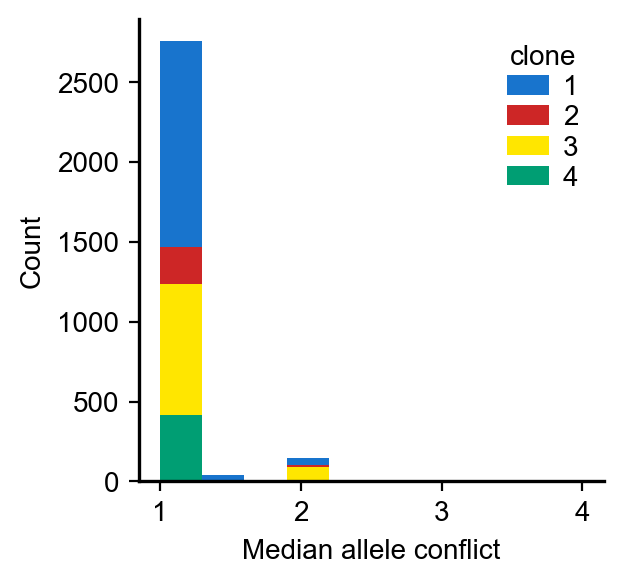

In [23]:
filtered_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["cellBC","intID","HEK3","EMX1","RNF2"]).first().reset_index()
filtered_alleles["n_alleles"] = filtered_alleles.groupby(["clone","cellBC","intID"]).intID.transform("count")
n_alleles = filtered_alleles.groupby(["clone","cellBC"]).n_alleles.median().reset_index(name = "n_alleles")
doublets = n_alleles.query("n_alleles > 1")["cellBC"]
sns.histplot(n_alleles,x = "n_alleles",hue = "clone",multiple = "stack",bins = 10,alpha = 1,linewidth = 0)
plt.xlabel("Median allele conflict");

Resolve remaining conflict by selecting the brightest spot

In [24]:
filtered_alleles = filtered_alleles[~filtered_alleles.cellBC.isin(doublets)].copy()
filtered_alleles = filtered_alleles.sort_values("intBC_intensity",ascending = False).groupby(
    ["intID","cellBC"]).first().reset_index().drop(columns = ["n_alleles"])

Mark doublets

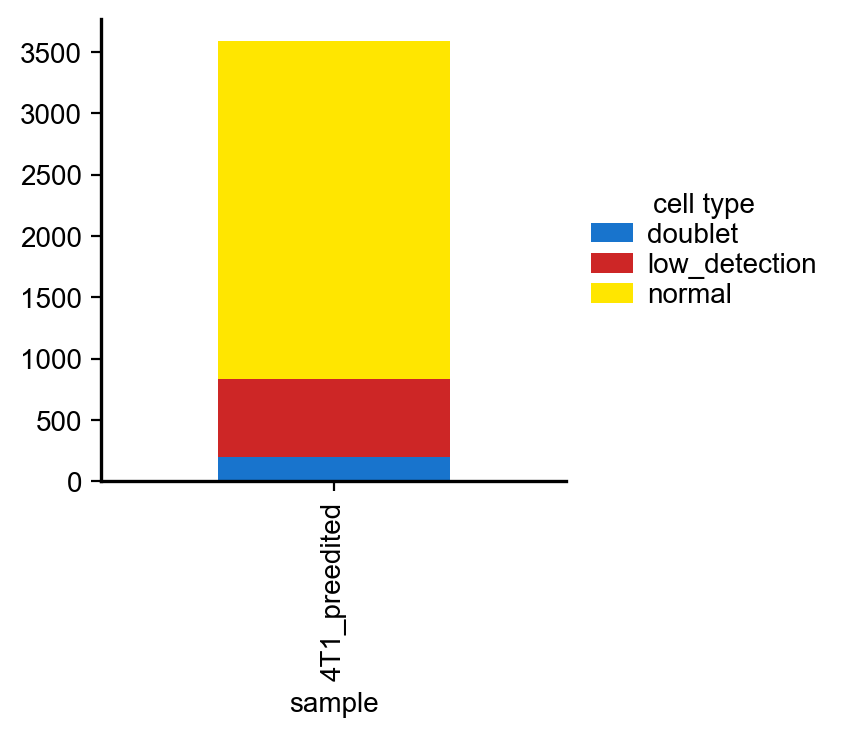

In [25]:
adata.obs.loc[(adata.obs["type"] == "normal") & (adata.obs.cellBC.isin(doublets)), "type"] = "doublet"
adata.obs.loc[adata.obs["type"] != "normal", "clone"] = None
adata.obs.groupby(['sample', 'type'],observed=False).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.legend(loc='center left', title='cell type', bbox_to_anchor=(1, 0.5))

## Allele statistics

In [ ]:
normal_cells = adata.obs.query("type == 'normal'").index
filtered_alleles = filtered_alleles.query("cellBC.isin(@normal_cells)").copy()

Edit probability vs brightness

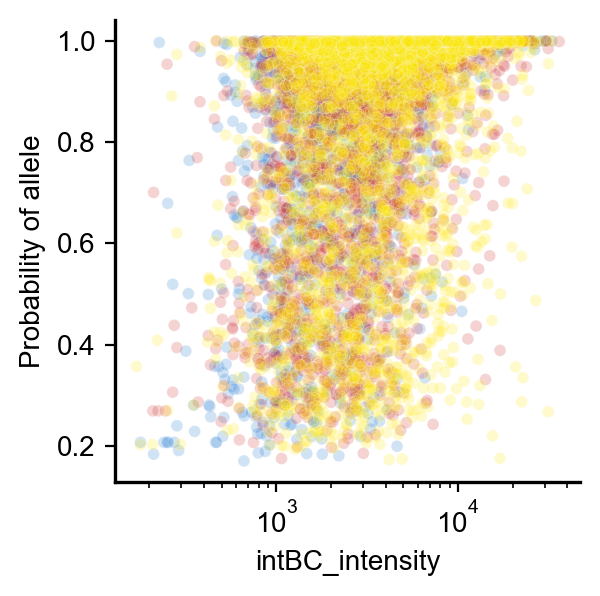

In [26]:
fig, ax = plt.subplots()
for i, site in enumerate(site_names):
    sns.scatterplot(filtered_alleles.sample(5000), x = "intBC_intensity", y = f"{site}_prob",
                    legend=False,alpha = 0.2,size = .1,ax = ax)
plt.xscale("log");
plt.ylabel("Probability of allele");

<Axes: xlabel='clone', ylabel='detection_rate'>

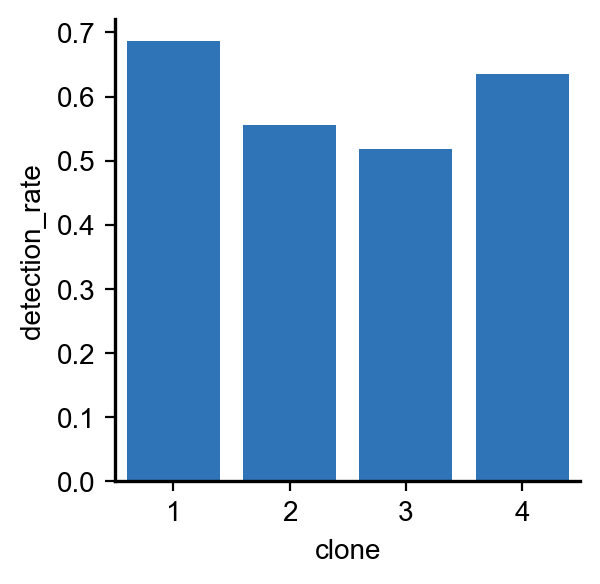

In [27]:
int_detection = (filtered_alleles.query("whitelist").groupby(["intID","clone","sample"]).size() / 
                 filtered_alleles.query("whitelist").groupby(["clone","sample"])["cellBC"].nunique())
int_detection = int_detection.reset_index(name = "detection_rate")
sns.barplot(data = int_detection.groupby(["clone"]).agg({"detection_rate":"mean"}).reset_index(),y = "detection_rate",x = "clone")

Detection rate per integration

<Axes: xlabel='clone', ylabel='intID'>

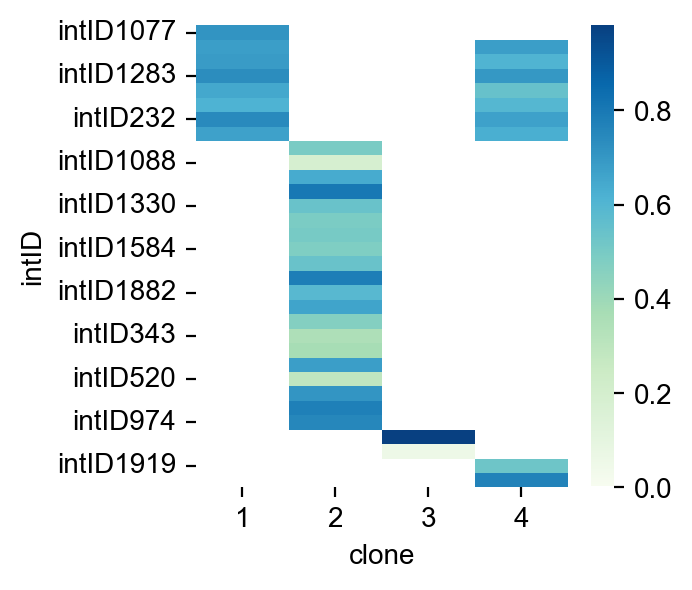

In [28]:
int_order = int_detection.intID.drop_duplicates()
int_detection_wide = pd.pivot_table(int_detection,columns=["clone"], index=["intID"], values="detection_rate")
sns.heatmap(int_detection_wide.loc[int_order,:],cmap = sequential_cmap,vmin = 0)

Edit fraction

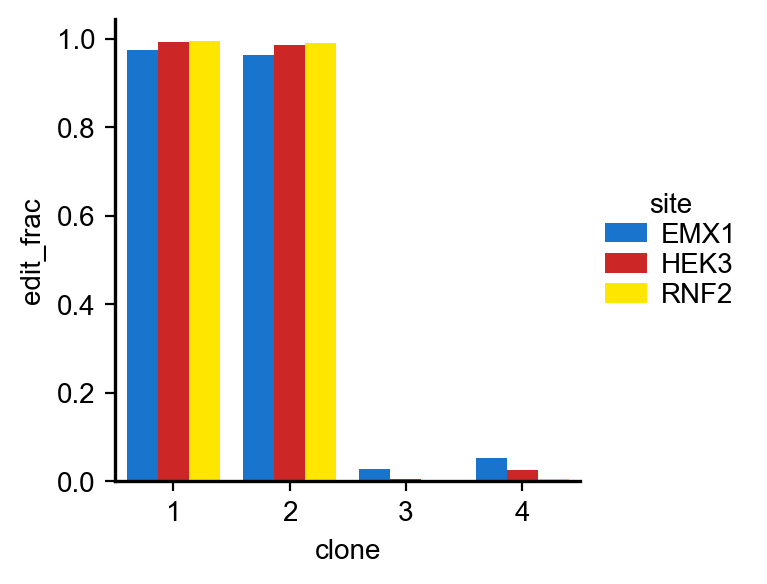

In [29]:
edit_counts = filtered_alleles.query("whitelist")[site_names + ["cellBC","intID","clone","sample"]].melt(
    id_vars = ["cellBC","intID","clone","sample"],value_name="edit", var_name="site")
edit_frac = edit_counts.query("edit != 'None'").groupby(["clone","sample","intID","site"]).size()/ \
    edit_counts.groupby(["clone","sample","intID","site"]).size()
edit_frac = edit_frac.reset_index(name = "edit_frac").groupby(["clone","site"]).agg({"edit_frac":"mean"}).reset_index()
sns.barplot(data = edit_frac,y = "edit_frac",x = "clone",hue = "site",saturation=1)
plt.legend(loc='center left', title='site', bbox_to_anchor=(1, 0.5))

Edit frequency

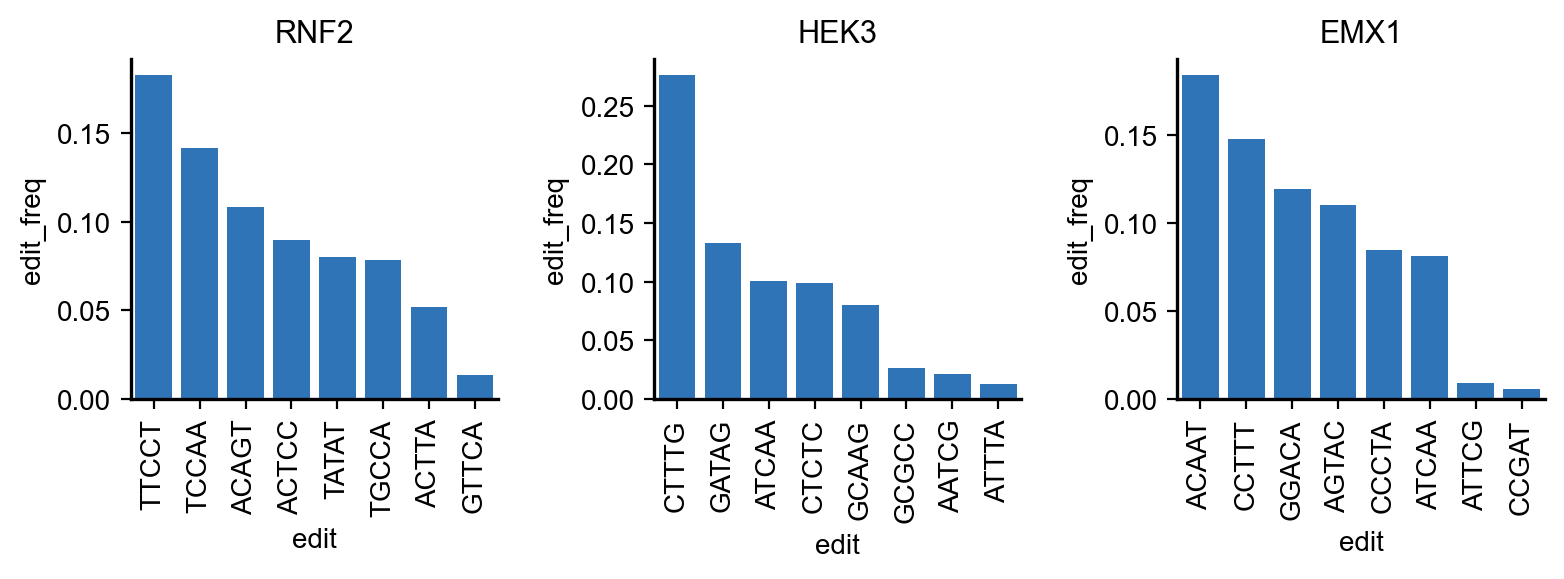

In [30]:
edit_frequency =  edit_counts.groupby(["site","edit"]).size() / edit_counts.groupby(["site"]).size()
edit_frequency = edit_frequency.reset_index(name = "edit_freq")

fig, axes = plt.subplots(1, 3, figsize=(8, 3))
for i, site in enumerate(site_names):
    sns.barplot(
        data=edit_frequency.query(f"site == '{site}' & edit != 'None'").sort_values("edit_freq", ascending=False).head(15),
        x="edit",y="edit_freq", ax=axes[i])
    axes[i].set_title(site)
    plt.setp(axes[i].get_xticklabels(), rotation=90)

plt.tight_layout()

## Write data

In [31]:
name = "merfish_zombie"
adata.obs.to_file(data_path / f"{name}_cells.json", driver='GeoJSON')
filtered_alleles.drop(columns = ["intensity","RNF2_actual","HEK3_actual","EMX1_actual"]
                      ).to_csv(data_path / f"{name}_alleles.csv",index = False)